<a href="https://colab.research.google.com/github/GioVergona/FacialFeaturesRecognition/blob/main/Facial_feature_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Import di librerie e download dei dati**

Si importano le librerie di base e si accede al Drive dove è stato caricato l'intero Dataset **CelebA** di immagini di volti

In [ ]:
%reset -f
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -q -n /content/drive/MyDrive/Progetto/img_align_celeba.zip

Mounted at /content/drive


 **2. Preparazione dei dati**

Si estraggono dal file *list_attr_celeba.txt* le 40 labels, i nomi dei file .jpg e per ognuno di essi i valori degli attributi corrispondenti

(1 = presente o -1 = non presente)

In [ ]:
import linecache

#Utilizzo linecache per la lettura di una singola riga da un file .txt

#La funzione header_extraction estrae da un file .txt la riga contenente i soli nomi delle labels e ritorna una lista

def header_extraction(header):
  first_line = linecache.getline('/content/drive/MyDrive/Progetto/list_attr_celeba.txt',2)  #Estraggo la seconda riga come un'unica stringa
  for word in first_line.split():   #La funzione split separa ogni parola della stringa estratta
    header.append(word)             #La parola viene posta in coda alla lista da restituire

#La funzione lines_extraction estrae da un file .txt le successive righe contenenti i nomi dei file e relativi attributi

def lines_extraction(data):
  with open('/content/drive/MyDrive/Progetto/list_attr_celeba.txt', 'r') as f:
    list_rows = f.readlines()
    for line in list_rows[2:101300]:
      row = list()     #Lista temporanea che conterrà le singole parole presenti in ogni riga del file
      for word in line.split():
        row.append(word)
      data.append(row)    #Si genera così una lista di liste: ogni lista interna contiene nome e attributi della singola immagine

#N.B. Il Dataset è stato dimezzato per ridurre le tempistiche in fase di addestramento

In [ ]:
header = list()
header.append('File_name')    #Si aggiunge una colonna all'header per i nomi dei file
header_extraction(header)

data = list()
lines_extraction(data)

for i in range(len(data)):    #Si cambiano tutti i -1 con degli 0
  for j in range(len(data[i])):
    if data[i][j] == '-1':
      data[i][j]='0'

Si generano 3 file CSV, corrispondenti a **training-set**, **validation-set**, **test-set**

In [ ]:
import csv

#Usando il prefisso with apriamo un file (in scrittura dato che spedifichiamo il parametro 'w') e non è necessario esplicitarne la chiusura (evitiamo di scirvere f.close())
#Writer è l'oggeto che permette la scrittura del file
#Writerow e writerows sono i due metodi che scrivono 1 o più righe

with open('train.csv', 'w') as f:
  writer=csv.writer(f)
  writer.writerow(header)
  writer.writerows(data[0:70910])

with open('valid.csv', 'w') as f:
  writer=csv.writer(f)
  writer.writerow(header)
  writer.writerows(data[91170:101300])

with open('test.csv', 'w') as f:
  writer=csv.writer(f)
  writer.writerow(header)
  writer.writerows(data[70910:91170])

Si leggono i 3 file CSV usando la libreria **pandas** e, dopo una fase di augmentation tramite **ImageDataGenerator**, si procede al caricamente delle immagini con il metodo *flow_from_dataframe*

In [ ]:
from tensorflow import keras
from keras import layers
from keras_preprocessing.image import ImageDataGenerator
from keras import optimizers
import pandas as pd

#Si utilizza la libreria pandas per leggere il contenuto di un file CSV tramite il metodo read_csv() ottenendo in uscita un oggetto DataFrame ovvero una tabella bidimensionale

train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")
valid_df = pd.read_csv("/content/valid.csv")

#Si utilizza ImageDataGenerator per specificare le operazioni di augmentation da applicare ai 3 data_set (normalizzazione, rotazione random,
#ridimensionamento, traslazioni verticali e orizzontali)

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, zoom_range=[0.9,1.1], width_shift_range=0.05, height_shift_range=0.05)
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

#Si utilizza il metodo flow_from_dataframe specificando: il DataFrame da cui leggere i valori degli attributi e il percorso alla cartella contenente le immagini
#per generare i batch di dati normalizzati e modificati tramite augmentation. Restituisce un DataFrameIterator contenente delle tuple caratterizzate dai batch
#delle immagini e le corrispondenti labels/attributi

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/img_align_celeba',
    x_col="File_name",
    y_col=header[1:],
    class_mode="raw",
    batch_size = 32,
    shuffle=True,
    target_size=(320,320)
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/content/img_align_celeba',
    x_col="File_name",
    y_col=header[1:],
    class_mode="raw",
    batch_size = 32,
    shuffle=False,  #Per il test set bisogna settarlo a False perchè le immagini vanno presentate in ordine per poter essere associate correttamente ai rispettivi nomi dei file
    target_size=(320,320)
)
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory='/content/img_align_celeba',
    x_col="File_name",
    y_col=header[1:],
    class_mode="raw",
    batch_size = 32,
    shuffle=True,
    target_size=(320,320)
)

#N.B. Le class_mode sono tutte impostate a raw in quanto sono solo di tipo numerico (nel nostro caso 0 o 1)

Found 70910 validated image filenames.
Found 20260 validated image filenames.
Found 10128 validated image filenames.


**3. Definizione dell'architettura di EfficientNetB3**

Utilizziamo la funzione **EfficientNetB3** di **Keras** per costruire l'architettura di rete neurale alla quale aggiungiamo uno strato di *GlobalAveragePooling2D* e uno strato finale Dense per ottenere in uscita i 40 attributi

In [ ]:
base_model = keras.applications.EfficientNetB3 (weights='imagenet', input_shape=(320,320,3), include_top=False)

#Essendo EfficientNetB3 un modello già pre-addestrato carichimo i pesi da ImageNet ed escludiamo i livelli densi per effettuare il fine-tuning

model = keras.models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())

#Aggiungiamo un livello denso a 40 uscite per le nostre esigenze

model.add(layers.Dense(40,activation='sigmoid'))

#N.B. La funzione sigmoide è efficiente per classificazione binaria

model.summary()

43950080/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 40)                61480     
                                                                 
Total params: 10,845,015
Trainable params: 10,757,712
Non-trainable params: 87,303
_________________________________________________________________


**4. Addestramento della rete**

Si addestra la rete con una tecnica di **fine-tuning** (addestrando solo 140 livelli di 210), utilizzando l'ottimizzatore **Adam**, una loss function di *Binary Crossentropy* e come metrica l'*Area Under roc Curve*. Tali parametri sono stati scelti in quanto concepiti appositamente per problemi di classificazione binaria

In [ ]:
#Blocchiamo il training di 70 livelli (empiricamente abbiamo ottenuto i risultati migliori)

num_levels = 70
for level in base_model.layers[0:num_levels]:
  level.trainable=False
model.summary()

model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['AUC',])
dat = model.fit(train_generator, epochs=5, steps_per_epoch=443, validation_data=valid_generator, verbose=1)
model.save_weights('new_weights2.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 40)                61480     
                                                                 
Total params: 10,845,015
Trainable params: 10,704,994
Non-trainable params: 140,021
_________________________________________________________________
Epoch 1/5
443/443 [==============================] - 520s 1s/step - loss: 0.2977 - auc: 0.9088 - val_loss: 0.2823 - val_auc: 0.9221
Epoch 2/5
443/443 [==============================] - 474s 1s/step - loss: 0.2431 - auc: 0.9427 - val_los

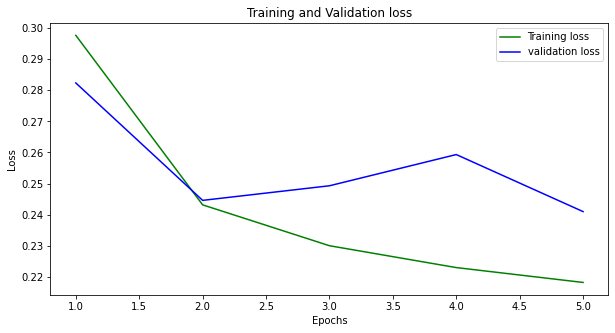

In [ ]:
#Si visualizzano gli andamenti delle loss sui dati di training e validation per ogni epoca

plt.figure(figsize=[10,5])
loss_train = dat.history['loss']
loss_val = dat.history['val_loss']
epochs = range(1,6)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

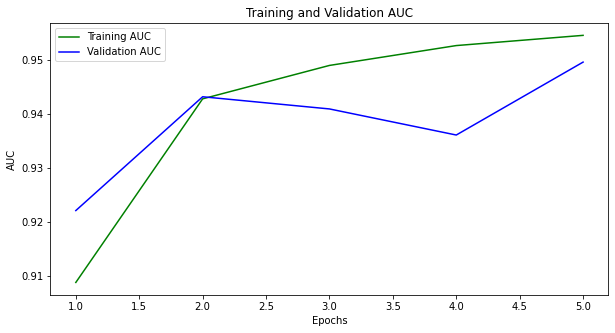

In [ ]:
#Si visualizzano gli andamenti delle AUC sui dati di training e validation per ogni epoca

plt.figure(figsize=[10,5])
auc_train = dat.history['auc']
auc_val = dat.history['val_auc']
epochs = range(1,6)
plt.plot(epochs, auc_train, 'g', label='Training AUC')
plt.plot(epochs, auc_val, 'b', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [ ]:
#N.B. Le seguenti istruzioni servono per caricare i pesi della rete preventivamente ed evitare di eseguire
#l'addestramento ogni volta. Se si effettua il fit nel blocco di codice precedente non eseguire il corrente blocco di codice.

'''
num_levels = 70
for level in base_model.layers[0:num_levels]:
  level.trainable=False
model.summary()
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['AUC',])
model.load_weights('/content/drive/MyDrive/Progetto/weights1.h5')
'''

"\nnum_levels = 70\nfor level in base_model.layers[0:num_levels]:\n  level.trainable=False\nmodel.summary()\nmodel.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['AUC',])\nmodel.load_weights('/content/drive/MyDrive/Progetto/weights1.h5')\n"

**5. Valutazione delle prestazioni**

Si valutano le prestazioni della rete appena addestrata sul test-set tramite la funzione *sklearn.metrics.roc_auc_score*

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix
import tqdm

#Creiamo due liste in cui conserviamo le etichette dei 40 attributi effettivi (y_true) di ogni immagine del test-set,
#e altre 40 etichette ottenute invece dalla predizione della rete (y_pred) delle stesse immagini

y_true = list()
y_pred = list()
test_generator.reset()

for _ in tqdm.tqdm(range(len(test_generator))):
  x_t, y_t = next(test_generator)
  p_t = model.predict(x_t)
  y_true.append(y_t)
  y_pred.append(p_t)
y_true = np.concatenate(y_true,0)
y_pred = np.concatenate(y_pred,0)

#Dal momento che abbiamo 40 attributi su cui valutare l'area under roc curve eseguiamo 40 cicli in cui calcoliamo le performance per ogni immagine rispetto ogni attributo


100%|██████████| 634/634 [03:59<00:00,  2.64it/s]


In [ ]:
#Si stampano i risultati di performance (roc_auc_score) confrontando i valori ottenuti dalla predizione rispetto la ground truth per ogni attributo

result = list()
for i in range(40):
  auc = roc_auc_score(y_true=y_true[:,i], y_score=y_pred[:,i])
  result.append(auc)
  print(header[i+1], ': ',auc)


5_o_Clock_Shadow :  0.9479000258234676
Arched_Eyebrows :  0.8983807148610471
Attractive :  0.8987714318909857
Bags_Under_Eyes :  0.8610047175712967
Bald :  0.9940224466101396
Bangs :  0.9837656400503855
Big_Lips :  0.7495922055021287
Big_Nose :  0.8665228757579726
Black_Hair :  0.9386253912155674
Blond_Hair :  0.9790454561125748
Blurry :  0.9525482310998907
Brown_Hair :  0.8635099787485313
Bushy_Eyebrows :  0.926489317968549
Chubby :  0.9433815499179241
Double_Chin :  0.9542397070782912
Eyeglasses :  0.9980490393248899
Goatee :  0.9799760211461633
Gray_Hair :  0.9789701815130725
Heavy_Makeup :  0.9734549685286007
High_Cheekbones :  0.9464479370220166
Male :  0.9968593126003061
Mouth_Slightly_Open :  0.9768915389963655
Mustache :  0.9659381986778065
Narrow_Eyes :  0.8557370286773602
No_Beard :  0.9773843759992811
Oval_Face :  0.7116872721203787
Pale_Skin :  0.9081223511664878
Pointy_Nose :  0.7817447887102791
Receding_Hairline :  0.9382461455903903
Rosy_Cheeks :  0.9499490412930711
Side

<BarContainer object of 40 artists>

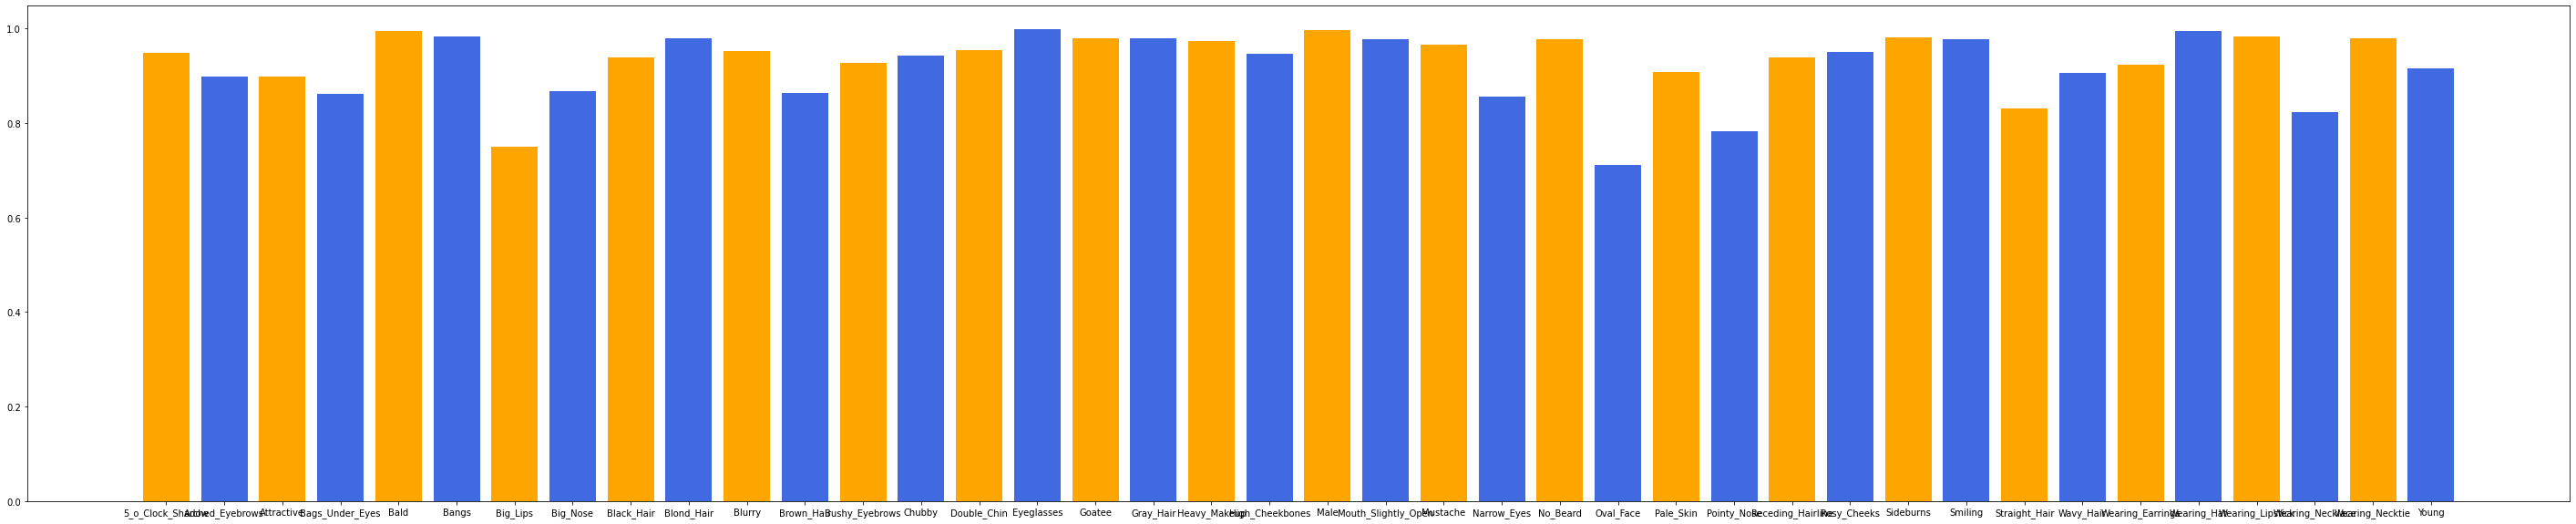

In [ ]:
#Si visualizzano con un diagramma le performance di predizione rispetto ogni attributo

plt.figure(figsize=[50,10])
plt.bar(header[1:], result, color = ['orange','royalblue'])